In [1]:
import pandas as pd
import numpy as np
import os
from datetime import datetime

In [2]:
datadirs = ["Jan07-Jan10","Jan10-onward"]

In [3]:
%%time
dfs = []
for datadir in datadirs:
    for root,dirs,files in os.walk(datadir):
        for file in files:
            name = file.split("_")[0]
            df = pd.read_csv(root+"/"+file,header=None)
            df.columns = ["datestr","twt","open","high","low","close","adjclose"]
            df["name"] = [name]*df.shape[0]
            dfs.append(df)

df = pd.concat(dfs,axis=0)
df["twt"] = df["twt"].astype(str)
df["twtarr"] = df["twt"].apply(lambda text: text.lower().split())

print(df.shape)
df = df[df["datestr"] != ""]
print(df.shape)
df["date"] = df["datestr"].apply( \
    lambda date: datetime.strptime(date,"%Y-%m-%d"))

(408127, 9)
(408127, 9)
CPU times: user 12.5 s, sys: 1.15 s, total: 13.6 s
Wall time: 19 s


Open, High, Low, Close, Adj Close

In [12]:
import gensim
%time w2vM = gensim.models.Word2Vec(df["twtarr"])

CPU times: user 1min 53s, sys: 1.84 s, total: 1min 55s
Wall time: 1min


In [13]:
# number of samples to aggregate
Ns = int(1e6)

In [15]:
%%time
# MEAN AGGREGATION
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).mean(axis=0)
#                  for twt in df["twtarr"][:Ns]])
# tvecs = np.array([np.array([w2vM[t]
#                             for t in twt
#                             if t in w2vM]).mean(axis=0)
#                  for twt in df["twt"][:Ns]])
# SUM AGGREGATION
# tvecs = np.array([np.array([w2vM[t] if t in w2vM
#                                 else np.zeros((100,))
#                             for t in twt]).sum(axis=0)
#                  for twt in sentDf["SentimentText"][:Ns]])
# MEAN AGGREGATION
# %time df["twtvecs"] = df["twtarr"][:Ns].apply(\
#     lambda twt: np.array([w2vM[t] \
#                          if t in w2vM else np.zeros((100,)) \
#                          for t in twt]).mean(axis=0))
%time df["twtvecs"] = df["twtarr"][:Ns].apply(\
    lambda twt: np.array([w2vM[w] \
                          for w in twt\
                          if w in w2vM]).mean(axis=0))

/Users/aduriseti/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: RuntimeWarning: Mean of empty slice.
  if __name__ == '__main__':


CPU times: user 43.2 s, sys: 2.13 s, total: 45.4 s
Wall time: 56.5 s
CPU times: user 43.2 s, sys: 2.13 s, total: 45.4 s
Wall time: 56.5 s


In [16]:
print(df.shape)
%time veclens = df["twtvecs"].apply(lambda vec: int(np.prod(vec.shape)))
df_empty = df[veclens != 100]
%time df = df[veclens == 100]
print(df.shape)

(408127, 11)
CPU times: user 4.47 s, sys: 317 ms, total: 4.79 s
Wall time: 5.69 s
CPU times: user 59.9 ms, sys: 23.9 ms, total: 83.8 ms
Wall time: 113 ms
(403024, 11)


In [51]:
%%time
namedatedf = df[["date","name","open"]].groupby(["name","date"]).aggregate(lambda gp: tuple(set(gp))[0])
# datedf = df[["date","name","open"]].groupby(["date"]).aggregate(lambda gp: tuple(set(gp))[0])

for name in namedatedf.index.levels[0]:
    pval = namedatedf.loc[name,"open"].values.astype(float)
    up = ((pval[1:] - pval[:-1]) > 0).astype(int)
    up = list(up) + [0]
    namedatedf.loc[name,"openup"] = up

CPU times: user 1.97 s, sys: 1.1 s, total: 3.07 s
Wall time: 4.45 s


In [52]:
%%time
namedategps = df[["date","name","twtvecs"]].groupby(["name","date"])
# namedatekeys = [k for k,gp in namedategps]
namedatevecs = [np.mean(gp.values[:,2],axis=0) for k,gp in namedategps]

CPU times: user 8.81 s, sys: 537 ms, total: 9.35 s
Wall time: 10.3 s


In [53]:
%%time
namedatedf["namedatevecs"] = namedatevecs

CPU times: user 1.59 ms, sys: 403 µs, total: 2 ms
Wall time: 1.89 ms


In [63]:
%%time
df["openup"] = df[["name","date"]].apply(\
    lambda nd: namedatedf.loc[(nd[0],nd[1]),"openup"],\
    axis = 1)

CPU times: user 4min 31s, sys: 7.37 s, total: 4min 38s
Wall time: 6min 4s


In [56]:
import sklearn
from sklearn import ensemble,svm,neural_network,discriminant_analysis
from sklearn.metrics import roc_curve,auc,precision_recall_curve

from matplotlib import pyplot as plt
% matplotlib inline

def roc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    fpr, tpr, thresholds = roc_curve(y, probs[:, 1])
    roc_auc = auc(fpr, tpr)
    roc_str = 'ROC (AUC Gain = %0.2f)' % (roc_auc - 0.5)
    plt.plot(fpr, tpr, lw=1,label=roc_str)
    plt.plot([0,1],[0,1],label="RAN CLF")
    plt.title(roc_str)
    plt.show()

def prrc_auc(clf,X,y):
    probs = clf.predict_proba(X)
    pr, rc, thresholds = precision_recall_curve(y, probs[:, 1])
    roc_auc = auc(rc, pr)
    roc_str = 'Prec vs Recall (AUC Gain = %0.2f)' % (roc_auc - np.mean(y))
    plt.plot(rc,pr, lw=1,label=roc_str)
    plt.plot([0,1],[np.mean(y),np.mean(y)],label="RAN CLF")
    plt.axis([0,1,0,1])
    plt.title(roc_str)
    plt.show()

def evaluate(clf,X,y):
    yhat = clf.predict(X)
    accu = np.mean(yhat == y)
    prec = np.mean(y[yhat == 1])
    recl = np.mean(yhat[y == 1])
    f1 = 2 * prec * recl / (prec + recl)
    print("Accuracy",accu,"Precision",prec,"Recall",recl,"F1",f1)

In [73]:
namedatedf.iloc[-5:]

open  openup  \
name date                            
TXN  2017-05-02  79.160004     1.0   
     2017-05-24  80.300003     1.0   
     2017-05-26  80.860001     1.0   
     2017-07-21  81.459999     1.0   
     2017-09-27  88.480003     0.0   

                                                      namedatevecs  
name date                                                           
TXN  2017-05-02  [0.0592978, -0.0283377, 0.223126, 0.125032, 0....  
     2017-05-24  [0.644305, -0.211111, 0.0163964, 0.121538, 0.0...  
     2017-05-26  [0.443938, -0.606893, -0.467474, 0.624851, -0....  
     2017-07-21  [0.343834, -0.145501, -0.0450594, 0.0799796, 0...  
     2017-09-27  [0.626472, -0.194325, 0.155123, 0.38399, 0.017...

# Average of tweets in a day

In [ ]:
named

In [ ]:
X = np.array(name)

In [88]:
X = np.array([v for v in namedatedf["namedatevecs"]])
y = namedatedf["openup"].values
# inverse classifier
# y = 1 - y

In [89]:
print(X.shape,y.shape)

(15926, 100) (15926,)


In [90]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(X.shape[0]) < ratio
pidx = ~tidx

In [91]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
clf = rf
%time clf.fit(X[tidx],y[tidx])

CPU times: user 803 ms, sys: 28.4 ms, total: 831 ms
Wall time: 1.19 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

TEST
Accuracy 0.519460138104 Precision 0.522625559423 Recall 0.647965474723 F1 0.578585191302
CPU times: user 8.88 ms, sys: 3.63 ms, total: 12.5 ms
Wall time: 10.7 ms
TRAIN
Accuracy 0.591130298273 Precision 0.580066773835 Recall 0.721248462485 F1 0.64299910904
CPU times: user 21 ms, sys: 2.64 ms, total: 23.6 ms
Wall time: 23.7 ms
ROC AUC


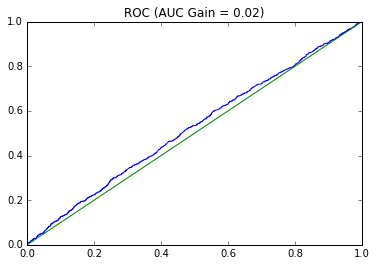

CPU times: user 260 ms, sys: 33.7 ms, total: 294 ms
Wall time: 331 ms
PRECISION/RECALL AUC


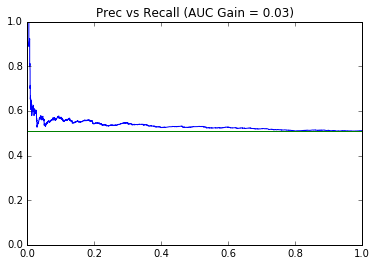

CPU times: user 280 ms, sys: 15.3 ms, total: 295 ms
Wall time: 572 ms


In [92]:
print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 16.7 s, sys: 1.42 s, total: 18.1 s
Wall time: 20.3 s
TEST
Accuracy 0.528307888041 Precision 0.547603833866 Recall 0.52512254902 F1 0.536127619643
CPU times: user 10.4 ms, sys: 6.04 ms, total: 16.4 ms
Wall time: 12.8 ms
TRAIN
Accuracy 0.691477716966 Precision 0.700881612091 Recall 0.68513388735 F1 0.692918287938
CPU times: user 41.6 ms, sys: 18.7 ms, total: 60.3 ms
Wall time: 38.8 ms
ROC AUC


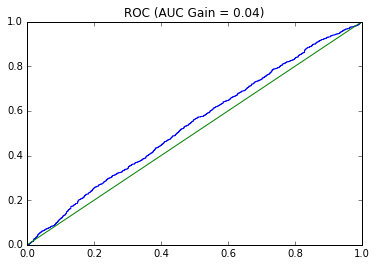

CPU times: user 973 ms, sys: 1.36 s, total: 2.33 s
Wall time: 4.31 s
PRECISION/RECALL AUC


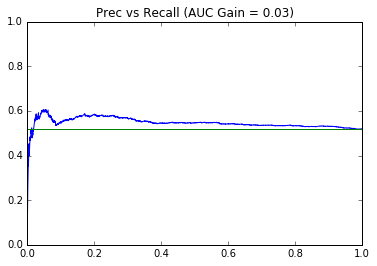

CPU times: user 310 ms, sys: 19.7 ms, total: 330 ms
Wall time: 619 ms


In [349]:
mlp = sklearn.neural_network.MLPClassifier()
clf = mlp
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 328 ms, sys: 60.5 ms, total: 389 ms
Wall time: 734 ms
TEST
Accuracy 0.492684478372 Precision 0.523870967742 Recall 0.248774509804 F1 0.33734939759
CPU times: user 19.2 ms, sys: 7.64 ms, total: 26.8 ms
Wall time: 21.7 ms
TRAIN
Accuracy 0.563017982799 Precision 0.647612861319 Recall 0.306863650354 F1 0.416414325989
CPU times: user 70.2 ms, sys: 40.2 ms, total: 110 ms
Wall time: 134 ms
ROC AUC


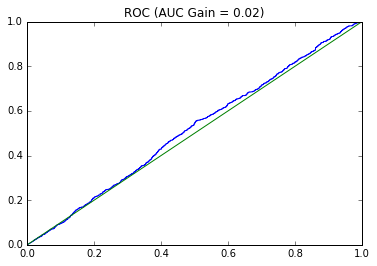

CPU times: user 319 ms, sys: 20.5 ms, total: 339 ms
Wall time: 852 ms
PRECISION/RECALL AUC


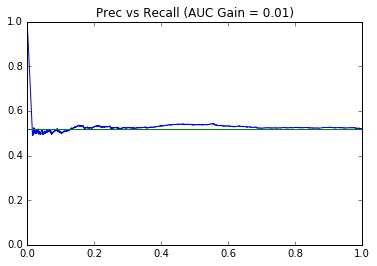

CPU times: user 306 ms, sys: 16.3 ms, total: 322 ms
Wall time: 600 ms


In [350]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
clf = qda
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

# Single tweets

In [64]:
# number of samples to train on
N = int(1e6)
X = np.array([x.T for x in df["twtvecs"][:N].values])
y = df["openup"][:N].values
# inverse classifier
# y = 1 - y

In [65]:
print(X.shape,y.shape)

(403024, 100) (403024,)


In [66]:
N

1000000

In [67]:
# generate test/train split
ratio = 0.8
tidx = np.random.rand(min(X.shape[0],N)) < ratio
pidx = ~tidx

CPU times: user 28.7 s, sys: 536 ms, total: 29.3 s
Wall time: 33.5 s
TEST
Accuracy 0.515480830907 Precision 0.514173073132 Recall 0.944251375615 F1 0.665798810527
CPU times: user 132 ms, sys: 32.1 ms, total: 164 ms
Wall time: 168 ms
TRAIN
Accuracy 0.518216774963 Precision 0.514963402205 Recall 0.948019274231 F1 0.66739714513
CPU times: user 392 ms, sys: 54.3 ms, total: 446 ms
Wall time: 454 ms
ROC AUC


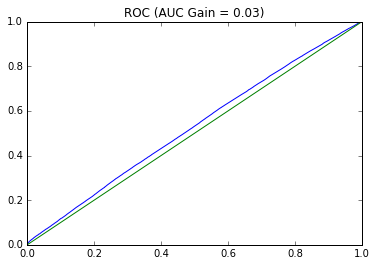

CPU times: user 349 ms, sys: 44.3 ms, total: 393 ms
Wall time: 410 ms
PRECISION/RECALL AUC


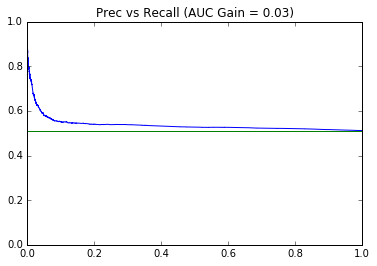

CPU times: user 351 ms, sys: 23.6 ms, total: 375 ms
Wall time: 384 ms


In [71]:
rf = sklearn.ensemble.RandomForestClassifier()
rf.max_depth = 5
clf = rf
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 12min 43s, sys: 53 s, total: 13min 36s
Wall time: 14min 18s
TEST
Accuracy 0.550518008112 Precision 0.556436937147 Recall 0.572917917798 F1 0.56455717177
CPU times: user 1.33 s, sys: 427 ms, total: 1.75 s
Wall time: 1.65 s
TRAIN
Accuracy 0.598902766072 Precision 0.603597357044 Recall 0.622449347466 F1 0.612878415874
CPU times: user 5.21 s, sys: 876 ms, total: 6.09 s
Wall time: 6.22 s
ROC AUC


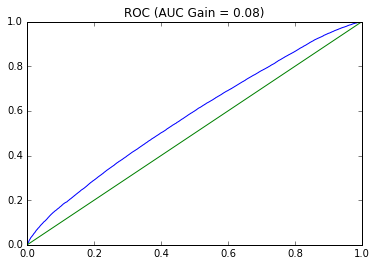

CPU times: user 1.63 s, sys: 211 ms, total: 1.84 s
Wall time: 1.74 s
PRECISION/RECALL AUC


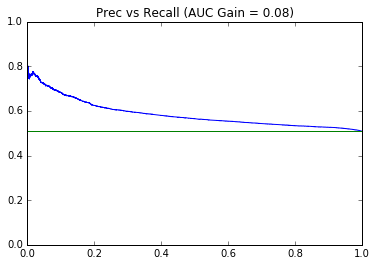

CPU times: user 2.28 s, sys: 2.28 s, total: 4.56 s
Wall time: 7.45 s


In [381]:
mlp = sklearn.neural_network.MLPClassifier()
clf = mlp
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])

CPU times: user 12.1 s, sys: 1.49 s, total: 13.6 s
Wall time: 21.2 s
TEST
Accuracy 0.522332991253 Precision 0.540507666208 Recall 0.405630690144 F1 0.463455468643
CPU times: user 468 ms, sys: 364 ms, total: 832 ms
Wall time: 927 ms
TRAIN
Accuracy 0.533019691978 Precision 0.556394052641 Recall 0.416870959214 F1 0.476631790109
CPU times: user 2.2 s, sys: 2.01 s, total: 4.21 s
Wall time: 6.05 s
ROC AUC


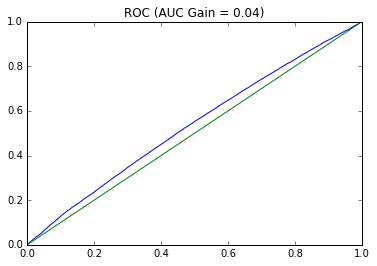

CPU times: user 819 ms, sys: 307 ms, total: 1.13 s
Wall time: 1.62 s
PRECISION/RECALL AUC


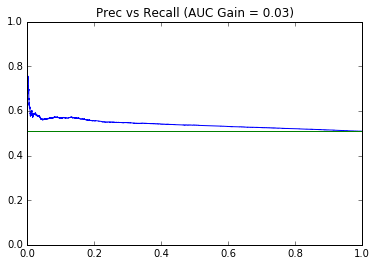

CPU times: user 849 ms, sys: 237 ms, total: 1.09 s
Wall time: 1.51 s


In [382]:
qda = sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis()
clf = qda
%time clf.fit(X[tidx],y[tidx])

print("TEST")
%time evaluate(clf,X[pidx],y[pidx])

print("TRAIN")
%time evaluate(clf,X[tidx],y[tidx])

print("ROC AUC")
%time roc_auc(clf,X[pidx],y[pidx])

print("PRECISION/RECALL AUC")
%time prrc_auc(clf,X[pidx],y[pidx])